# Model Optimization and Nonlinear Models

CSC/DSC 340 Week 5 Lecture Notes

Author: [Dr. Julie Butler](www.juliebutler.org)

Date Created: August 20, 2023

Last Modified: August 20, 2023

## Part 1: Hyperparameter Tuning

### Why do we need hyperparameter tuning?

We have been covering basic hyperparameter tuning for the past two weeks, but now that we are covering model optimization in detail we will take a more thorough look at hyperparameter tuning.

Hyperparameters are variables in a model that a user has to set before the model can be trained.  However, the value the user chooses for these variables can affect the results of the model.

If we consider ridge regression, the hyperparameter $\alpha$ controls how regularized the model is.  A very small value of $\alpha$ results in an unregularized model (equivalent to linear regression), but a very large value of $\alpha$ results in a highly regularized model that is usually a bad fit.  We can examine the effect of different $\alpha$ values on a new data set from Sci-kit learn called the California housing data set, which predicts the price of a house (in units of $100k) given information about the house such as its age and it average number of rooms, as well as information about the surrounding are like population and median income.  First we need to import various libraries and the data set.

In [1]:
##############################
##         IMPORTS          ##
##############################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score as score
from sklearn.datasets import fetch_california_housing

In [2]:
# Print the features
fetch_california_housing().feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [3]:
##############################
##        IMPORT DATA       ##
##############################
X, y = fetch_california_housing(return_X_y = True)

##############################
##        SCALE DATA        ##
##############################
scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

##############################
##     TRAIN-TEST SPLIT     ##
##############################
X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

Now we can train the model with a view different values of $\alpha$ and compare the results.

ALPHA: 1e-15 MSE: 0.5385006856668789
ALPHA: 0.01 MSE: 0.5385007720052859
ALPHA: 100.0 MSE: 0.5399747069672424
ALPHA: 10000.0 MSE: 0.7424641564380989
ALPHA: 1000000000000000.0 MSE: 1.3498672699729928


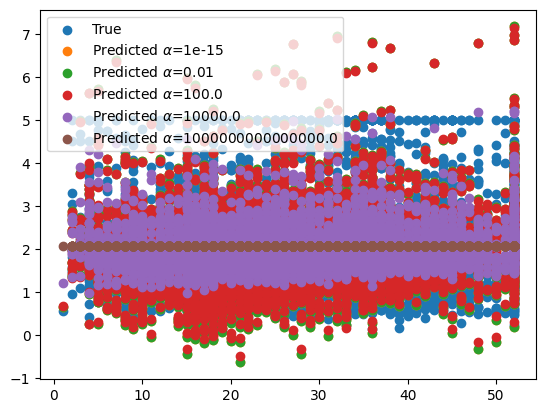

In [4]:

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
for alpha in [1e-15, 1e-2, 1e2, 1e4, 1e15]:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    err = MSE(y_pred, y_test)
    print("ALPHA:", alpha, "MSE:", err)

    plt.scatter(X_test_plot[:,1],y_pred,label=r'Predicted $\alpha$='+str(alpha))
plt.legend()

We can see that the value for $\alpha$ does not make a huge difference at small values, but as $\alpha$ starts to increase so does the error of the model. Figuring out this point where the error starts to increase is important so that we do not choose an $\alpha$ value higher than that.  However, in other data sets, a high degree of regularization could be needed, so choosing a value of $\alpha$ that is too low could also be detrimental to our model's performance.

While performing extensive hyperparameter tuning on a linear model like the ones we have studied so far may seem like overkill, beginning this week we will start looking at more complicated nonlinear models.  These nonlinear models have several hyperparamters and they models will be more sensitive to small changes in these parameters, so not only does hyperparameter tuning become more important, it also becomes more time extensive.  For the rest of this section of the lecture notes we will be looking at five different ways that can be used to find the optimal hyperparameter value for the ridge regression algorithm and now these method can be transferred to the more complicated linear models we will be studying for the remainder of the course.

### Methods for Hyperparameter Tuning

#### Using Default Values
All machine learning algorithms that are implemented in Scikit-Learn have default values for all of the hyperparameters. These are not neccessarily the best values, but using the defaults is the simplest method. 

For ridge regression, the default value of $\alpha$ is 1.0, which is a reasonably high level of regularization. Let's determine the performance of the default values on our housing data set. However, the entire housing data set is over 20,000 points, so in order to save time we will reduce the data set to just the first 1,000 points to perform hyperparameter tuning. This subset of the data set we use for the hyperparameter tuning is called the **validation data set**, and is either a subset of the entire data set or a subset of the training data set depending on the implementation.


In [5]:
# Make the data set smaller (20k+ points in total)
# More points = more data to generate patterns BUT more run time
X = X[:1000]
y = y[:1000]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [6]:
%%time
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

CPU times: user 736 µs, sys: 225 µs, total: 961 µs
Wall time: 846 µs


Not only are we interested in the accuracy of each tuning method, we also want to look at the run times. If a method can produce a very accurate method, but it has very high run times, it may not be the best choice.  Run time is even more important as we move to more complicated models and data sets. The `%%time` statement has to be the first line of the cell to produce the run time of the code cell. In this notebook we will be comparing the run times from just running each cell once, but in a true comparison of run times you will want to run each relevant cell many times and report the average run time as well as the standard deviation.  This also goes for reporting any errors/accuracy scores that have an element of randomness in them (such as the train-test split).  We will want to run the code many times to get an average accuracy over several possible data splits.

MSE: 0.29965000307452666


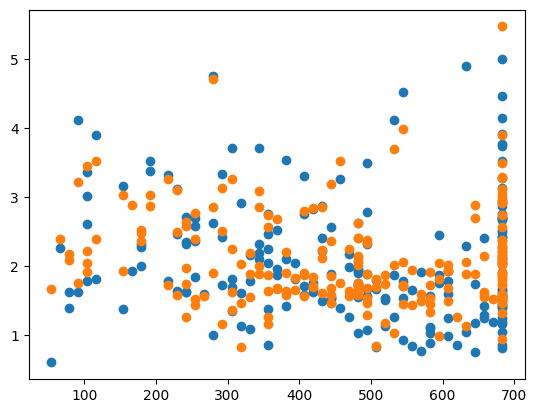

In [7]:
err = MSE(y_pred, y_test)
print("MSE:", err)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

The advantages of using the default values for the hyperparameters are that its a very fast method and it does not require any modifications to the code or algorithm.  However, the default values for the hyperparameters may not be the best values and no test are done to check to see if there are better values. The next three hyperparameter tuning methods we will look at check many different values (or combinations of values) to find the optimal set of hyperparameters.

#### For Loop Tuning

This is the the method we have been using for hyperparameter tuning so far, where we use a for loop to perform a brute force test over a given range of possible values to find the hyperparameter value that results in the lowest error (or highest accuracy score). If there is more than one hyperparameter, we can use nested for loops to check all possible combinations of hyperparameters in the ranges we are testing.

In [8]:
%%time
best_err = 1e4
best_alpha = None
for alpha in np.logspace(-15,4,1000):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    
    err = MSE(y_pred, y_test)
    
    if err < best_err:
        best_err = err
        best_alpha = alpha

CPU times: user 638 ms, sys: 1.9 ms, total: 640 ms
Wall time: 296 ms


MSE: 0.2996487006208541
CHOSEN ALPHA: 0.9704808877380326


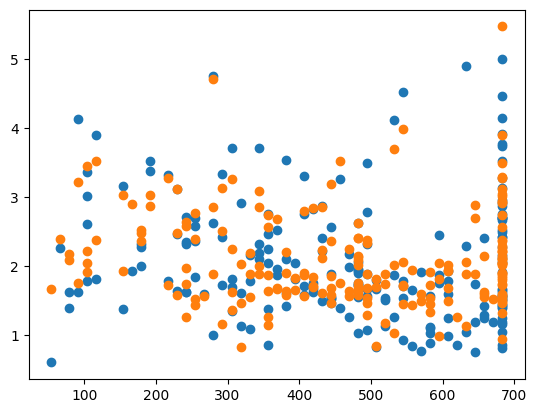

In [9]:
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print("CHOSEN ALPHA:", best_alpha)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

The advantages of the for loop method are that it checks more than one value of the hyperparameter to find the best value (it will check as many different values as we specify), its a simple concept that is relatively easy to implement, and it has short run times (compared to the next two methods). However, it is a long piece of code that grows longer as we have more hyperparamters to check and it does not check all possible values of the best hyperparameters, just the ones that are passed.

#### GridSearchCV (Scikit-Learn)

Scikit-Learn has several hyperparameter tuning implementations and we will be looking at two of them: [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). GridSearchCV is a brute force algorithm that checks every single hyperparameter it is given to find the best value, or every possible combination of hyperparameters if it is given more than one hyperparameter to optimize. This is the same process as the for loop tuning discussed in the last section, but GridSearchCV gives more information that the for loop implementation but it also has longer run times.  The below code applies GridSearchCV to our data set and extracts the best value of $\alpha$.  However, GridSearchCV has many more features that can be look at in the documenation (linked above).

In [10]:
%%time
from sklearn.model_selection import GridSearchCV

parameters = {'alpha':np.logspace(-15,4,5000)}

ridge = Ridge()

grid_search = GridSearchCV(ridge, parameters,\
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'alpha': 0.13293052652247003}
CPU times: user 13.2 s, sys: 43.2 ms, total: 13.3 s
Wall time: 12.9 s


MSE: 0.3014494621759448
CHOSEN ALPHA: 0.13293052652247003


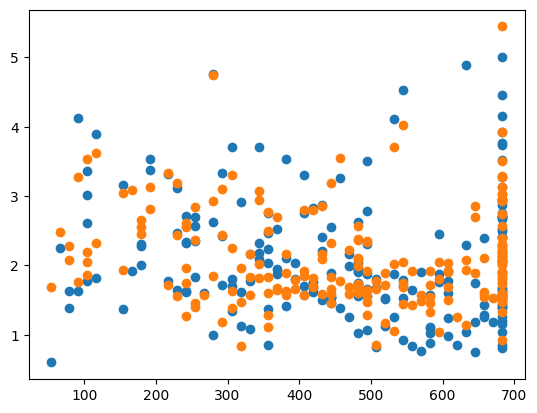

In [11]:
ridge = Ridge(alpha=grid_search.best_params_['alpha'])
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', grid_search.best_params_['alpha'])

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

The advantages of GridSearchCV is that it takes only a few lines of code to implement, and it gives you a lot of data on the fits once you train the algorithm.  However, GridSearchCV has very long run times compared to the previous two methods, and, like the for loop method, it only searches over a given range of parameters and does not consider other values (that could be better fits).

#### RandomizedSearchCV

RandomizedSearchCV takes a different approach. Instead of performing a brute force search over a given range of parameters, it randomly draws a given number of points from a distribution. In the below example, we are sampling points from a uniform distribution, but there are other options as well avalible [here](https://docs.scipy.org/doc/scipy/reference/stats.html) under the "Continuous distributions" heading. We choose the number of randomly sampled points by setting the `n_iter` argument.  Below, we are setting it to 5,000 points so that it is comparing the same number of values as the previous two methods so the run times are comparable.

In [12]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

distributions = {'alpha':uniform(loc=0, scale=4)}

ridge = Ridge()

random_search = RandomizedSearchCV(ridge, distributions,\
                                   scoring='neg_mean_squared_error', n_iter=5000)
random_search.fit(X_train, y_train)

print(random_search.best_params_, random_search.best_score_)

{'alpha': 0.13297727996882802} -0.29149683070373633
CPU times: user 13.3 s, sys: 162 ms, total: 13.5 s
Wall time: 13.1 s


MSE: 0.3014491645647441
CHOSEN ALPHA: 0.13297727996882802


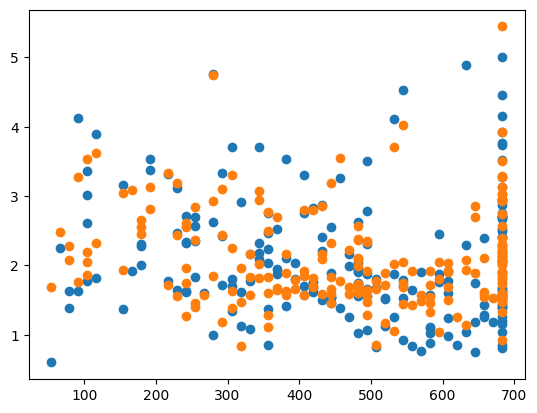

In [13]:
ridge = Ridge(alpha=random_search.best_params_['alpha'])
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', random_search.best_params_['alpha'])

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

The advantages of the RandomizedSearchCV method are the same as GridSearchCV (only a few line implementation and it gives a lot of data once it is trained). Additionally, unlike the for loop method and GridSearchCV, since this method draws points from a distribution, it is not constrained to a given range of values the user passes. However, it also has long run times.  This can be changed by lowering the `n_iter` value, but smaller values mean less values are tested.  Additionally, like the previous methods, it only searches a finite number of parameter combinations. 

#### Bayesian Ridge Regression

Bayesian ridge regression belongs to a classification of  machine learning algorithms called [Bayesian machine learning](https://machinelearningmastery.com/bayes-theorem-for-machine-learning/). Instead of using "normal" stastics to fit the models Bayesian machine learning makes use of [Bayesian statistics](https://en.wikipedia.org/wiki/Bayesian_statistics), which is based on [Bayes Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem).

Bayesian ridge regression uses Bayesian statistics to find the value of $\alpha$ that is statistically likely to result in the best model. This fixes the problems of the previous models where we could only search a finite number of values. We will not go into detail about how the Bayesian ridge regression algorithm determines the best value of $\alpha$, but if you are interested, the following links are a good starting place:

* [Scikit-Learn's website](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression)
* [Building Block AI](https://buildingblock.ai/bayesian-ridge-regression)
* [Towards Data Science](https://towardsdatascience.com/how-to-build-a-bayesian-ridge-regression-model-with-full-hyperparameter-integration-f4ac2bdaf329)


You will get different results when performing Bayesian ridge regresion compared to linear regression or ridge regression, and the results may not be as accurate as a throughly tuned ridge regression model. However, Bayesian ridge regression is much more robust than regular ridge regression and performs it hyperparameter tuning automatically.

In [14]:
%%time
from sklearn.linear_model import BayesianRidge

bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)
y_pred = bayesian_ridge.predict(X_test)

print(bayesian_ridge.alpha_)

3.5079737637644315
CPU times: user 7.04 ms, sys: 1 ms, total: 8.05 ms
Wall time: 2.84 ms


MSE: 0.29993182718830796
CHOSEN ALPHA: 3.5079737637644315


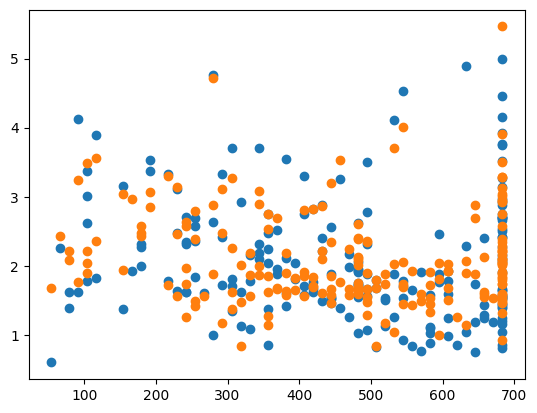

In [15]:
ridge = BayesianRidge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', ridge.alpha_)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

Bayesian ridge regression has very short run times and you can be sure that you have found the statistically best value of $\alpha$, instead of just the best value in a given finite range. It also only takes a couple of lines of code to implement. Unfortunately, Bayesian ridge regression only works for ridge regression (unlike the previous models which can be extended to other machine learning algorithms), but there are Bayesian machine learning implementations of most common machine learning algorithhms. [Gaussian processes](https://scikit-learn.org/stable/modules/gaussian_process.html) can be considered the Bayesian implementation of several nonlinear models, such as kernel ridge regression we will look at later in these notes. [Bayesian Neural Networks](https://arxiv.org/pdf/2007.06823.pdf) are the Bayesian implementation of neural networks.

## Part II: Feature Engineering

[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of eliminating or altering the inputs to a model in order to improve a model's predictive performance. We have already seen several examples of feature engineering the this class so far. Using a design matrix to modify the inputs is an example of feature engineering and so is scaling the data set using standard scaler since these alter the values of the inputs. We have also looked into removing some columns of a data frame before training our models, leaving only the most relevant features.  This is also feature engineering. 

Below we will attempt to improve the Bayesian ridge regression results applied to the California housing data set using various types of feature engineering.  First, we will import the data set as a Pandas DataFrame and then we will use the `sample` function to randomly select 1,000 points to use in our test to make the analysis faster.

In [16]:
import pandas as pd
import seaborn as sns

housing = fetch_california_housing()

housing_data = pd.DataFrame(housing.data, columns=housing.feature_names)

housing_data['target'] = housing.target

housing_data = housing_data.sample(1000)

The first thing we can do is create a pairplot using Seaborn to look for correlations between the data. We should pay particular attention to the bottom row of the output, as those are the correlations we are trying to help the model run (the target column as the dependent variable and the other columns as the independent variables).

/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


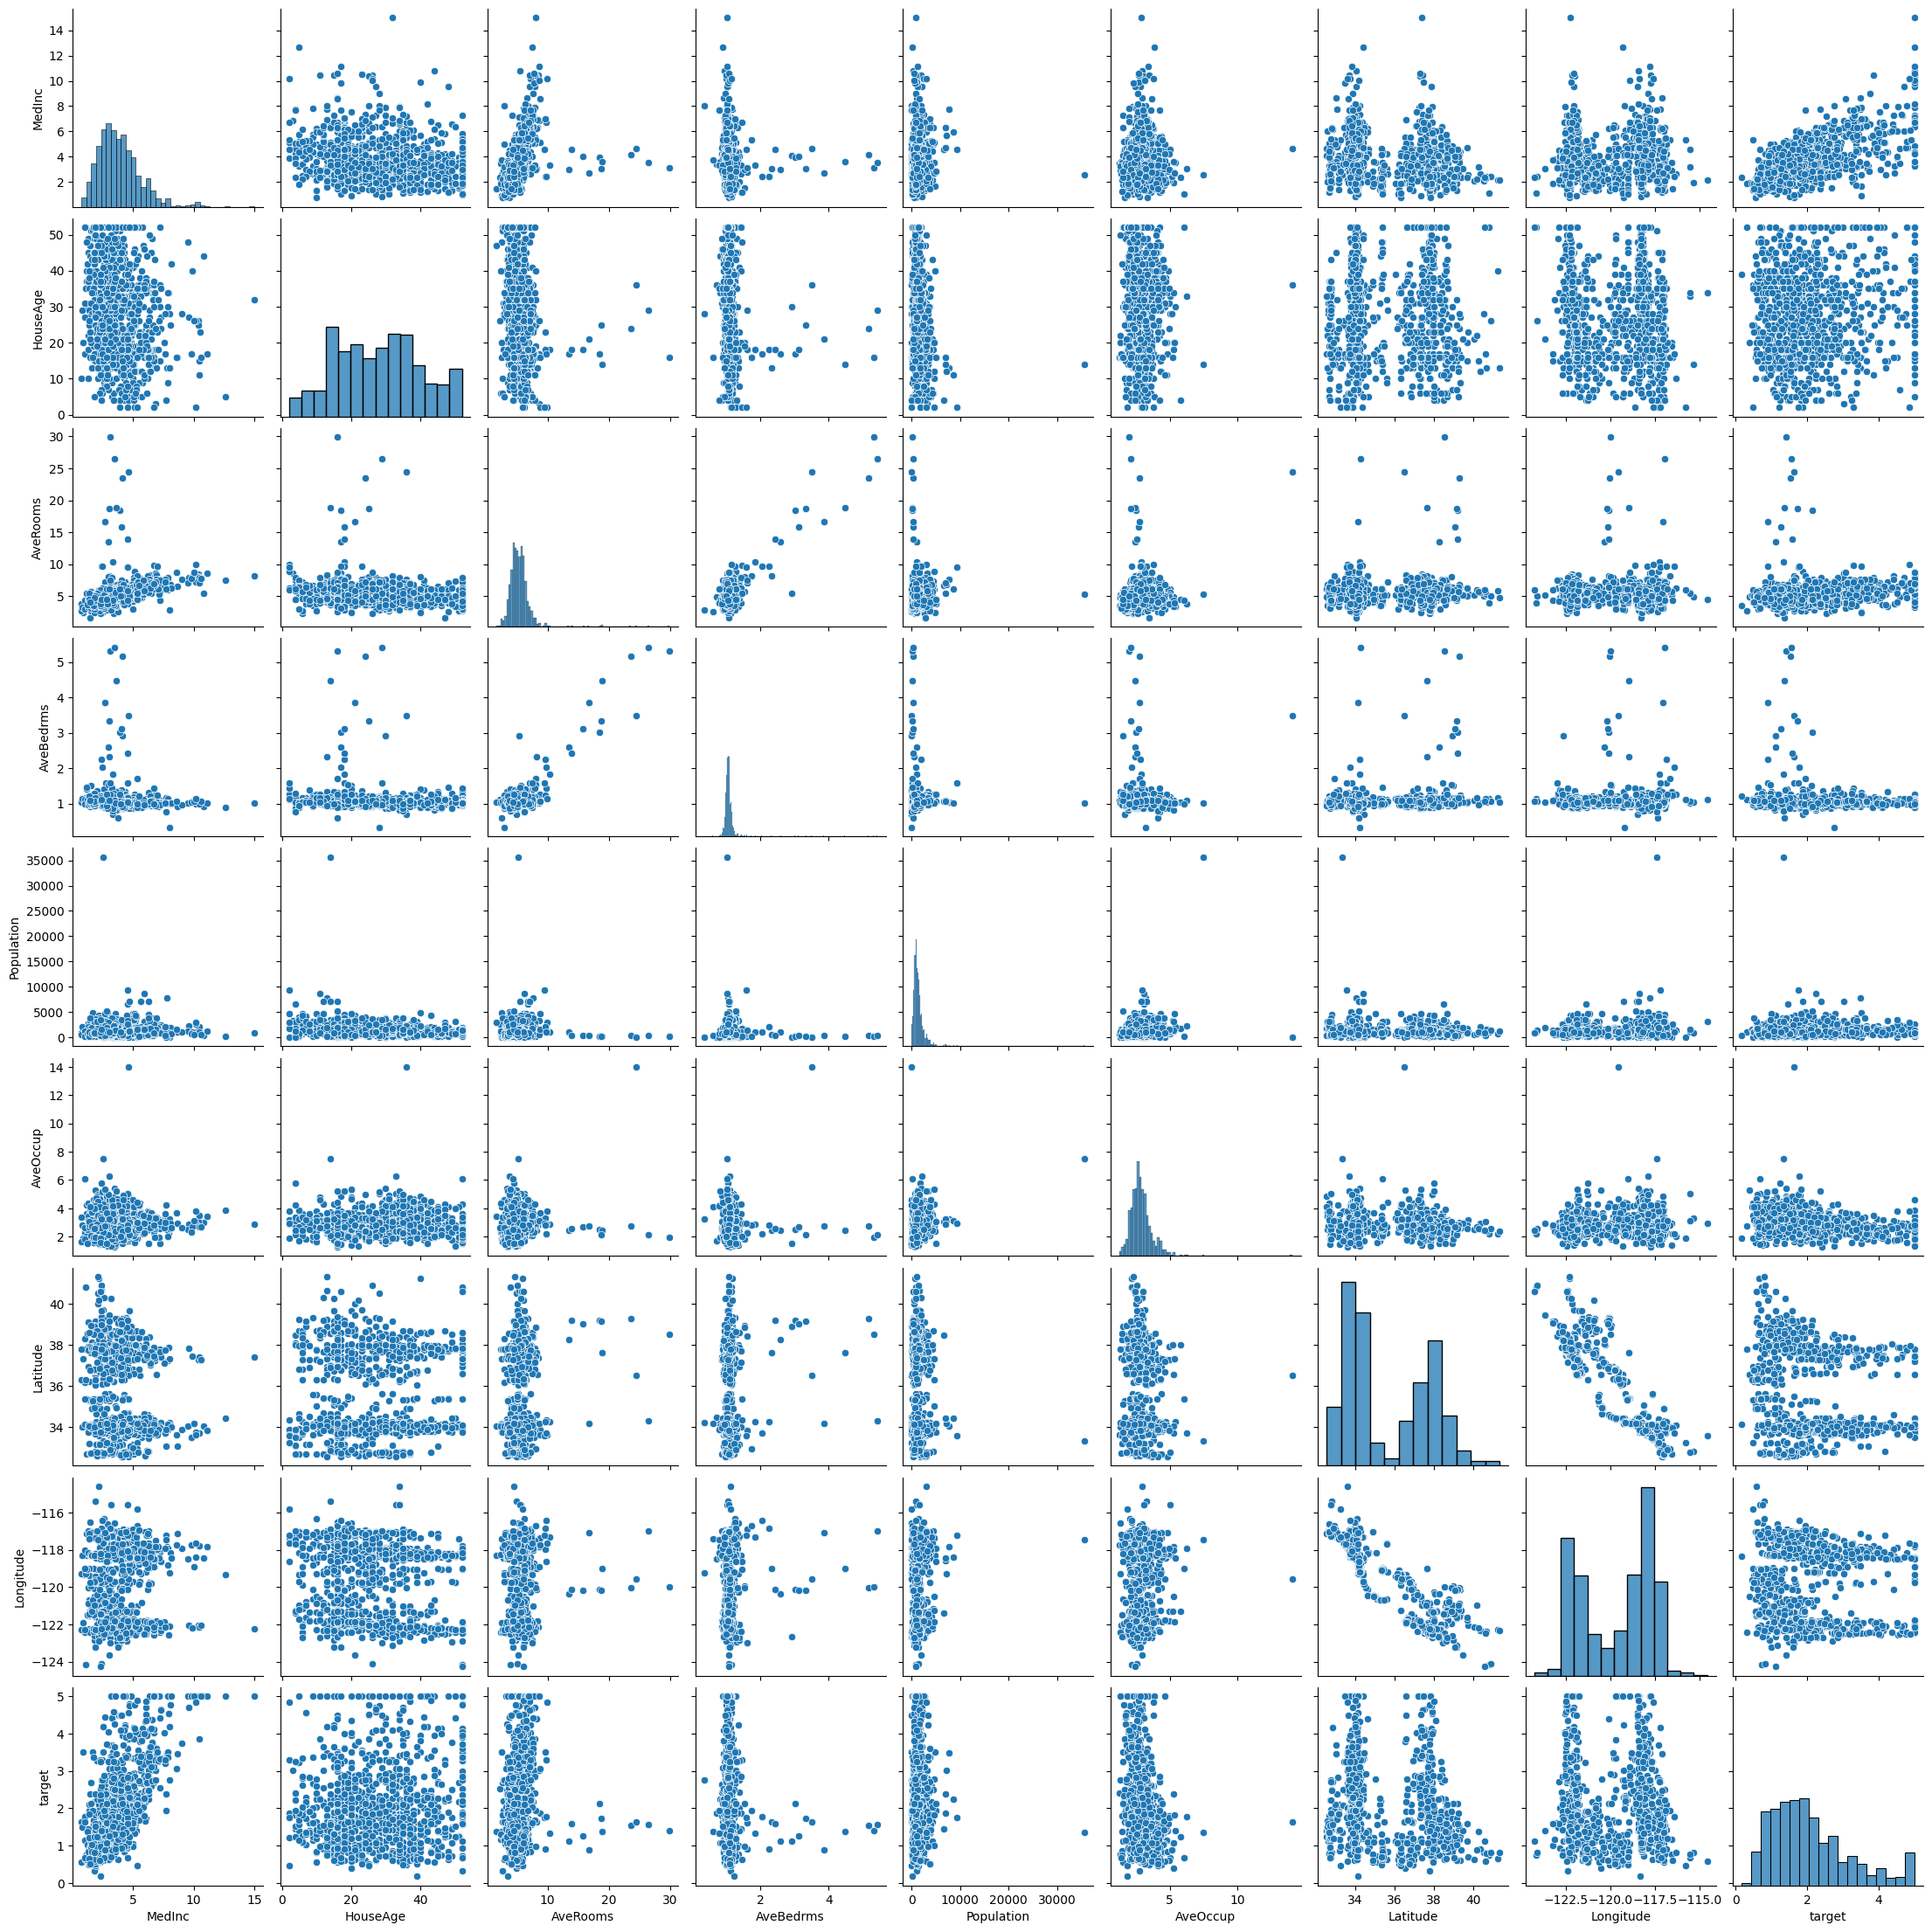

In [17]:
sns.pairplot(housing_data)

It can be hard to draw conclusions from this data set since in many cases there is no clear pattern or where then maybe a pattern it is not a linear pattern. Another way we can determine patterns in the data is to create a **correlation matrix**. A correlation matrix displays the correlation score (the square root of the R2-score) for all possible combinations of variables. The closer the correlation score is to $\pm 1$, the more linear the plot of those two variables will be (which is important when we are using linear models).  We can create a correlation matrix using the following code.

In [18]:
correlation_matrix = housing_data.corr()
correlation_matrix

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
MedInc,1.000000,-0.185583,0.391977,-0.081648,-0.004763,-0.005193,-0.063743,-0.017708,0.651168
HouseAge,-0.185583,1.000000,-0.188034,-0.077416,-0.237708,-0.009751,0.001094,-0.109600,0.079301
AveRooms,0.391977,-0.188034,1.000000,0.777403,-0.052323,0.104751,0.124733,-0.009820,0.133150
AveBedrms,-0.081648,-0.077416,0.777403,1.000000,-0.063132,0.002877,0.099226,0.025022,-0.082664
Population,-0.004763,-0.237708,-0.052323,-0.063132,1.000000,0.224197,-0.109404,0.100037,-0.017540
AveOccup,-0.005193,-0.009751,0.104751,0.002877,0.224197,1.000000,-0.155917,0.171381,-0.237492
Latitude,-0.063743,0.001094,0.124733,0.099226,-0.109404,-0.155917,1.000000,-0.922275,-0.097095
Longitude,-0.017708,-0.109600,-0.009820,0.025022,0.100037,0.171381,-0.922275,1.000000,-0.098079
target,0.651168,0.079301,0.133150,-0.082664,-0.017540,-0.237492,-0.097095,-0.098079,1.000000


We can also display the correlation matrix with `matshow` like we did with the confusion matrices. From this matrix we can see that the features most correlated with our housing prices is the median income in the area, and the second most correlated features are the average rooms in the house and the average occupancy of the house.

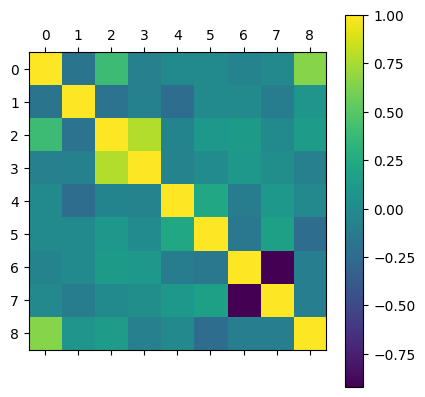

In [19]:
plt.matshow(correlation_matrix)
plt.colorbar()

From here we can train a chosen model (Bayesian ridge regression in this case) on the data without performing any feature engineering to get a base line score.  Then we will see if by performing any of the feature engineering methods if we can improve the score.

In [20]:
X = housing_data.drop(columns=['target'])
y = housing_data['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [21]:
ridge = BayesianRidge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', ridge.alpha_)


MSE: 0.3499180694071488
CHOSEN ALPHA: 2.0736881062171597


If we look at the pairplot graphs above, many of the graphs seem to have outliers (points whose values does not fit in with the general pattern). Generally it is acceptable to remove outliers from a training set as it is assumed outliers are difficult if not impossible to predict. However, we cannot just toss out points randomly because they do not fit our model.  Instead we need to perform statistical test to remove the outliers. The below cell does that using the [Z-score test](https://en.wikipedia.org/wiki/Standard_score). There are also other statistical test and models you can use to identify and remove outliers.  The below code removes the outliers and then reproduces the pairplot to make sure they have (mostly) been removed.

/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


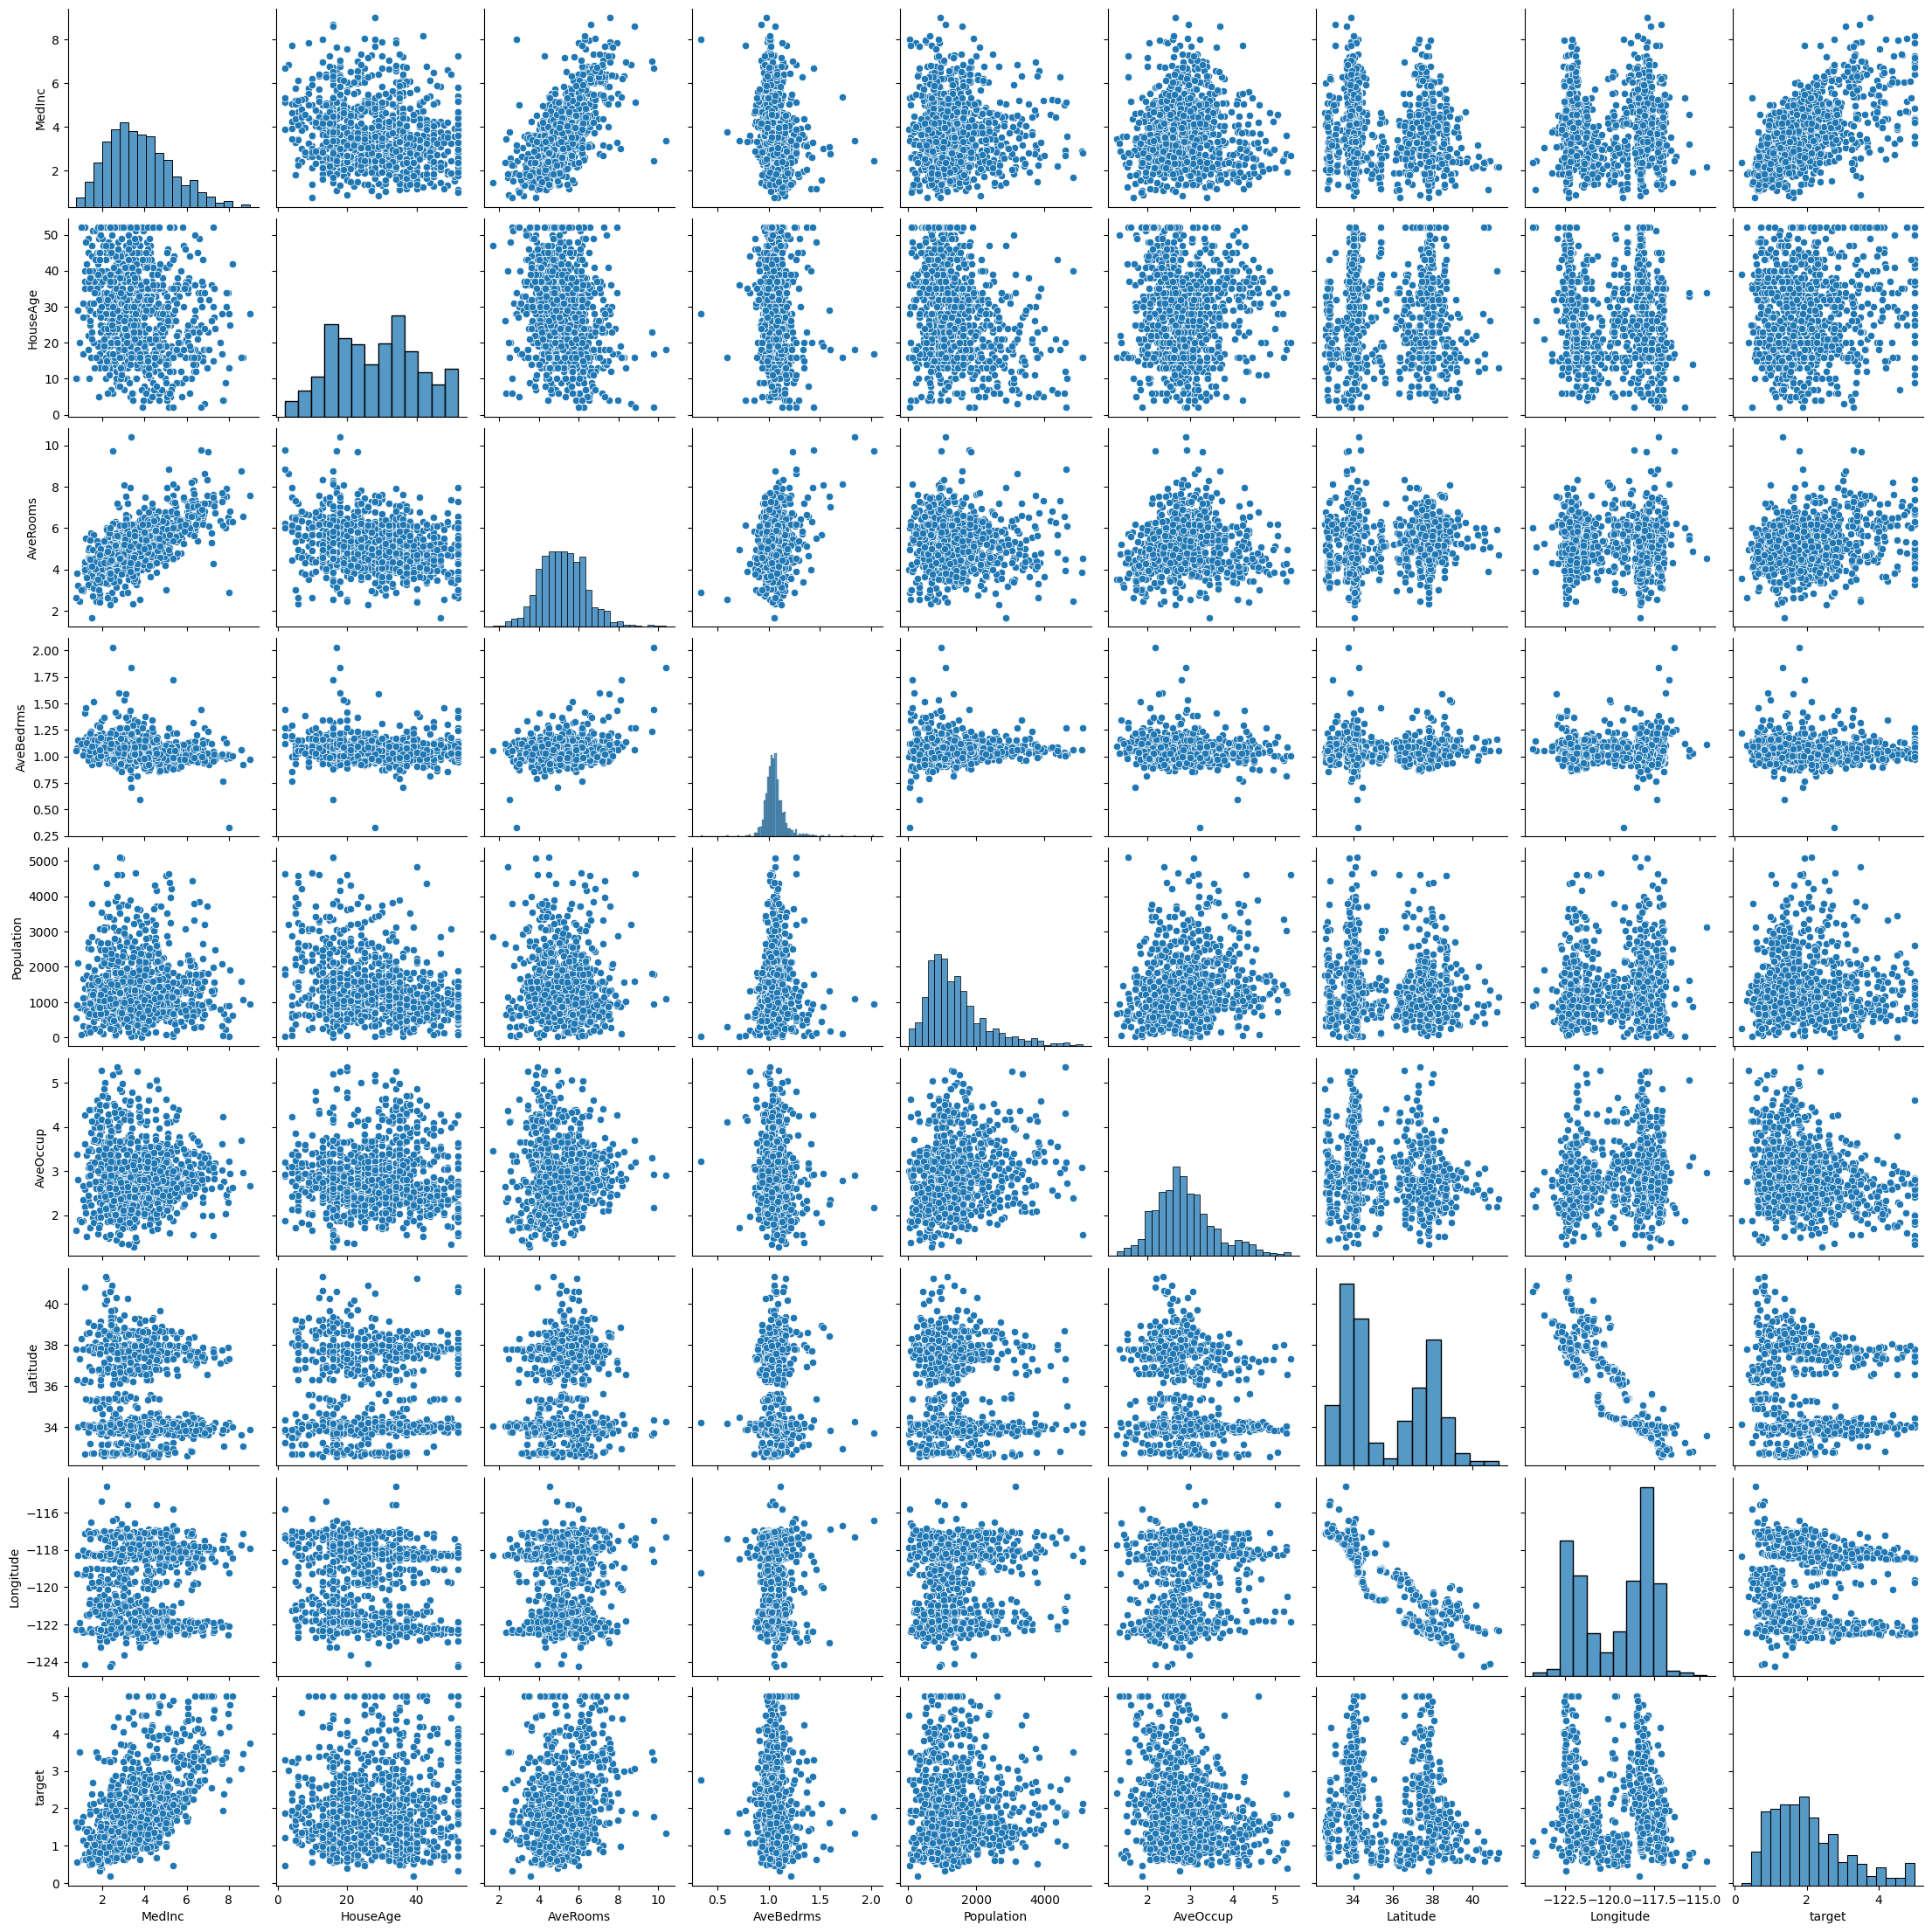

In [22]:
# Remove outliers from the data set and make the pairplot again

from scipy import stats

housing_data_no_outliers = housing_data[(np.abs(stats.zscore(housing_data)) < 3).all(axis=1)]

sns.pairplot(housing_data_no_outliers)

We can also recreate our correlation matrix to see if any of the relevant correlation scores have changed.

In [23]:
correlation_matrix = housing_data_no_outliers.corr()
correlation_matrix

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
MedInc,1.000000,-0.184528,0.664298,-0.218128,-0.017218,-0.013118,-0.072517,-0.001518,0.595204
HouseAge,-0.184528,1.000000,-0.231715,-0.074405,-0.302704,-0.012765,0.005555,-0.107843,0.100434
AveRooms,0.664298,-0.231715,1.000000,0.227421,-0.051267,0.052402,0.096328,-0.044082,0.229946
AveBedrms,-0.218128,-0.074405,0.227421,1.000000,0.037191,-0.119901,0.030745,0.018236,-0.060258
Population,-0.017218,-0.302704,-0.051267,0.037191,1.000000,0.192327,-0.103728,0.097139,-0.013426
AveOccup,-0.013118,-0.012765,0.052402,-0.119901,0.192327,1.000000,-0.169848,0.186525,-0.287374
Latitude,-0.072517,0.005555,0.096328,0.030745,-0.103728,-0.169848,1.000000,-0.929701,-0.097268
Longitude,-0.001518,-0.107843,-0.044082,0.018236,0.097139,0.186525,-0.929701,1.000000,-0.093685
target,0.595204,0.100434,0.229946,-0.060258,-0.013426,-0.287374,-0.097268,-0.093685,1.000000


Now we will perform the machine learning again on this outlier-less data set and see how the MSE score improved.

In [24]:
X = housing_data_no_outliers.drop(columns=['target'])
y = housing_data_no_outliers['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [25]:
ridge = BayesianRidge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', ridge.alpha_)

MSE: 0.3920892135021881
CHOSEN ALPHA: 2.260218628799585


It appears that the MSE is lower (so the model is a better fit) when we remove the outliers, though the exact results depend on the randomless of the `split` and `train_test_split` functions. Now let's reset our data test the effects of scaling the data on the model MSE.  We will revert to the data set with the outliers because we only want to measure once change at a time.

In [26]:
X = housing_data.drop(columns=['target'])
y = housing_data['target']

scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

In [27]:
ridge = BayesianRidge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', ridge.alpha_)

MSE: 0.5599649212138086
CHOSEN ALPHA: 2.327648364441302


Though the exact results depend on the random methods, the average MSE (if run several times) from the scaled data should be less than the unscaled MSE.  Next we are going to attempt feature engineering by removing some of the features to hopefully give the model a more clear picture of the relationships in the data set. Since the median income feature had the highest correlation score with the target data, let's try just using that one feature as our model input.

In [28]:
X = np.asarray(housing_data['MedInc']).reshape(-1,1)
y = np.asarray(housing_data['target'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [29]:
ridge = BayesianRidge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("RMSE:", np.sqrt(err))
print('CHOSEN ALPHA:', ridge.alpha_)

RMSE: 0.7943551419306852
CHOSEN ALPHA: 1.3844282063853675


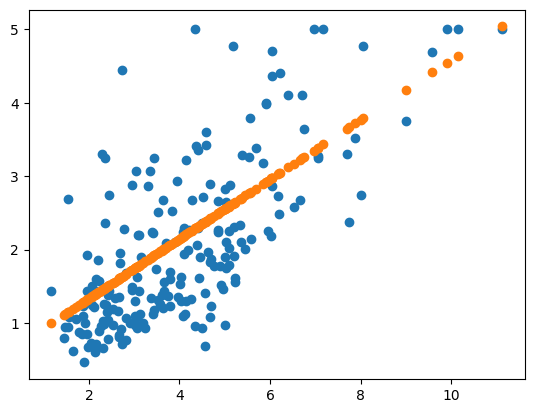

In [30]:
X_test = np.asarray(X_test)
plt.scatter(X_test[:,0], y_test)
plt.scatter(X_test[:,0],y_pred)

Unfortunately, with just one feature, even if it is highly correlated, the best fit we can get is a straight line through the data. Instead of just one feature, let's instead take the three features with the highest correlation scores and use those as the inputs to our model.

In [31]:
X = np.asarray(housing_data[['MedInc','AveRooms','AveOccup']])
y = np.asarray(housing_data['target'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [32]:
ridge = BayesianRidge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("RMSE:", np.sqrt(err))
print('CHOSEN ALPHA:', ridge.alpha_)

RMSE: 0.8080517079616615
CHOSEN ALPHA: 1.615792053436879


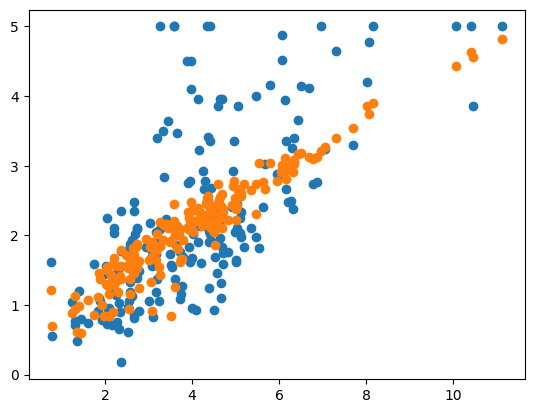

In [33]:
X_test = np.asarray(X_test)
plt.scatter(X_test[:,0], y_test)
plt.scatter(X_test[:,0],y_pred)

Even with the three most correlated features, the average MSE error is still higher than that of the model that included all of the data.  So it appears, that at least of this data set, that reducing the number of features does not actually improve the model performance. 

We have explored a few different methods of feature engineering (one at a time) on this data set.  However, in practice, you will likely attempt these three methods (and others) in various combinations to create a good model.  Part of being a good machine learning engineer is being good at formatting data in exactly the way a model needs to best find the patterns.  We will cover one more type of feature engineering next week (dimensionality reduction) and you can find plenty of examples of how other people format their data sets online (for example on kaggle.com).

We have done our best to model the California housing data set with ridge regression, performing both hyperparameter tuning and feature engineering to attempt to improve the results. However, while we have gotten some okay answers, we have not gotten a really good model yet. This could be because we are using a linear model (ridge regression) but our data set has nonlinear patterns.  In this case, we need to start using nonlinear machine learning models which can more throughly pick up on the nonlinear patterns in the data set.

## Part 3: Non-linear Models

All of the models we have studies so far in this course have been linear models, meaning that they are capable of modeling linear relationships in the data.  We can use design matrices to add some nonlinearity into the models but this only helps so much.  Therefore, we need to start looking machine learning models that have nonlinearity encoded into them. Examples of nonlinear models include kernel ridge regression (this week), support vector machines (not covered in this course), and neural networks (Weeks 7+).

### Kernel Ridge Regression

Kernel ridge regression (KRR) is essentially ridge regression, but it modifies its inputs by passing them through a nonlinear **kernel function**. This kernel function is what adds the nonlinearity into the model. A complete list of Scikit-Learn kernels are found [here](https://scikit-learn.org/stable/modules/metrics.html), but a few of the common ones are also listed below. 

* Linear: $k(x,y) = x^Ty$
* Polynomial: k(x,y) = $(\gamma x^Ty+c_0)^d$
* Sigmoid: $k(x,y) = tanh(\gamma x^Ty+c_0)$
* Radial Basis Function (RBF): $k(x,y) = exp(-\gamma||x-y||_2)$

Note that in the kernel functions, $\gamma$, $d$, and $c_0$ are hyperparameters.  The choice of kernel function itself can also be considered a hyperparameter. Thus without even considering the loss function we already have 1-4 hyperparameters per model.  This is why we covered hyperparameter tuning in depth earlier in these notes, our models are going to acquire an increasing number of hyperparameters as this class advances, making effecient and thorough hyperparameter important.

#### Kernel Ridge Regression Equations
The kernel ridge regression equations are going to be similar to ridge regression, but with the addition of the the kernel function. Thus, the outputs of a KRR algorithm can be models as $\hat{y}(x) = \sum_{i=1}^m\theta_ik(x_i,x)$, where k(x,y) is the kernel function and $x_i$ is an iteration through the m training points given to the model. The loss function is exactly the same as for ridge regression, being the MSE function with the L2-norm of the weights:  $J(\theta) = MSE(y,\hat{y}) + \frac{\alpha}{2}\sum_{i=1}^n\theta_i^2$. This means that in addition to the 1-4 hyperparameters that come from the kernel function, we still have the $\alpha$ hyperparameter.  We can still write a closed form solution for our optimized weights (the last model we can do this for).  Here we need to introduct the kernel matrix $K_{ij}=k(x_i,x_j)$ where both $x_i$ and $x_j$ iterate through the training data. Then the optimized weights for a kernel ridge ergression model can be written as $\theta = (\textbf{K}-\alpha\textbf{I})y$.

### Hyperparameter Tuning with Many Hyperparameters

In this section of the notes, we will attempt to perform hyperparameter tuning on the kernel ridge regression applied to the California housing data set. This will be a more complicated tuning because we have 5 hyperparameters to search over ($\alpha$, the kernel function, $\gamma$, $d$, $c_0$).  In this section we will be using the RandomizedSearchCV to perform the search, but the for loops or the GridSearchCV methods could be used as well. We will be using only 500 points for this hyperparameter tuning instead of 1,000 since this tuning is much more time intensive.

In [34]:
X,y = fetch_california_housing(return_X_y=True)

X = X[:500]
y = y[:500]

scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

Now let's perform the tuning to find the best set of parameters.

In [35]:
from sklearn.kernel_ridge import KernelRidge

distributions = {'alpha':uniform(loc=0, scale=4), 'kernel':['linear', \
                                                            'polynomial', 'rbf', \
                                                            'sigmoid', 'laplacian'], \
                 'gamma':uniform(loc=0, scale=4),\
                'degree':np.arange(0,10), 'coef0':uniform(loc=0, scale=4)}

krr = KernelRidge()

random_search = RandomizedSearchCV(krr, distributions,\
                                   scoring='neg_mean_squared_error', n_iter=500)
random_search.fit(X_train, y_train)
print(random_search)
print(random_search.best_params_, random_search.best_score_)

/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.62527e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.0463e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12319e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.03857e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


KeyboardInterrupt: 

Now let's test out best model (taken from one run on the above code) and test it's performance on the entire California housing data set and compare its results to performing Baysian ridge regression on the entire California housing data set.

In [39]:
X,y = fetch_california_housing(return_X_y=True)

scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

In [40]:
# Using the best parameters from through one run of the 
# RandomizedSearchCV method above
krr = KernelRidge(alpha= 0.35753693232459094, coef0= 3.2725118241858264, degree= 9, gamma= 0.14696609545731532, kernel= 'laplacian')
krr.fit(X_train, y_train)
y_pred = krr.predict(X_test)
print('MSE:', MSE(y_pred, y_test))

MSE: 0.2380564122097256


In [41]:
bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)
y_pred = bayesian_ridge.predict(X_test)
print('MSE:', MSE(y_pred, y_test))

MSE: 0.5282280190419684


The MSE for the tuned KRR algorithm is half that as for the Bayesian ridge regression algorithm, so it does appear that a nonlinear model is the best fit for this data set and that further hyperparameter tuning and feature engineering may be able to reduce this error further.